# Logistic Regression
Logistic regression is different from linear regression in that it is used for classification. In this notebook, we will use it for binary classification on generated data as well as a Kaggle data set for car purchases. Like linear regression, gradient descent for logistic regression uses the information at the current epoch to improve the model until it converges (hopefully).

## Libraries
The standard math library will be used for the exponential function. pandas DataFrames are good for data pre-processing but have slow indexing, so calculations for the algorithm will be done with NumPy arrays. scikit-learn has a function that splits the data into training and validation data sets. Finally, the progression of the model can be visualized using Matplotlib.

In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Algorithm
Since exponentials will be used, we need to normalize our data to make sure the loss does not cause overflow or other issues. Min-max normalization is simple but efficient, linearly scaling the data between 0 and 1.

$$v_{new}=\frac{v_{old}-\text{min}(v_{old})}{\text{max}(v_{old})-\text{min}(v_{old})}$$

In [2]:
def normalize_minmax(data):
    data = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))
    return data

Logistic regression uses the sigmoid function to make its prediction as a linear function will not return a value between 0 and 1.

$$\sigma(x)=\frac{1}{1+e^{-x}}$$

Since $x$ is a single value, we can represent it as a linear combination, $z$, of the data.

$$z=\beta_0+\beta_1x_1+\beta_2x_2+\ldots+\beta_mx_m$$

$$\sigma(z)=\frac{1}{1+e^{-z}}$$

The `z` function calculates this linear combination, and the `prob` function calculates $\sigma$, the model's prediction expressed as a probability.

In [3]:
def z(point, betas):
    return betas[0] + np.dot(betas[1:], point.T)

def prob(betas, point):
    u = z(point, betas)
    return 1 / (1 + math.exp(-u))

If we try to use mean squared error for logistic regression, the model will have difficulty converging to the minimum because there will be more than one local minimum. Therefore, we must use a different cost function, i.e. log loss.

$$J=-\frac{1}{n}\sum_{i=1}^{n} (y_i \log(\sigma_i)+(1-y_i)\log(1-\sigma_i))$$

The natural logarithm of the probability returned by the model is taken at each data point. Because both 0 and 1 are possible labels, the probability for label 0 is subtracted from 1 to calculate the confidence for a prediction of 0.

In [4]:
def log_loss(betas, data):
    rows, cols = data.shape
    loss = 0
    for i in range(rows):
        cli = data[i][cols - 1]
        pi = prob(betas, data[i][:cols - 1])
        loss += cli * math.log(pi) + (1 - cli) * math.log(1 - pi)
    loss *= -1 / rows
    return loss

We also want to keep track of the accuracy of the logistic regression, so the `accuracy` function predicts a class for each of the data points, and the proportion of correct predictions to total predictions is returned.

In [5]:
def accuracy(betas, data, threshold):
    rows, cols = data.shape
    acc = 0
    for i in range(rows):
        cli = data[i][cols - 1]
        pi = prob(betas, data[i][:cols - 1])
        acc += cli * pi + (1 - cli) * (1 - pi) >= threshold
    acc /= rows
    return acc

### Gradient Descent
The gradient descent for logistic regression uses the same fundamental formula as linear regression to update the $\beta$-values, but since the cost function is different, computation will slightly vary.

$$\beta_{k_{new}}=\beta_{k_{old}}-\alpha\frac{\partial J}{\partial \beta_k}$$

$$\frac{\partial J}{\partial \beta_k}=-\frac{1}{n}\sum_{i=1}^{n} \sigma_i(y_ie^{-z}+y_i-1) \text{    for } k=0$$
$$\frac{\partial J}{\partial \beta_k}=-\frac{1}{n}\sum_{i=1}^{n} \sigma_i(y_ie^{-z}+y_i-1)x_{k_i} \text{    for } k>0$$

In [6]:
def iterate(betas, data_train, data_test, epochs, learning_rate, threshold):
    metrics = {
        'loss_train': [log_loss(betas, data_train)],
        'loss_test': [log_loss(betas, data_test)],
        'acc_train': [accuracy(betas, data_train, threshold)],
        'acc_test': [accuracy(betas, data_test, threshold)]
    }
    rows, cols = data_train.shape
    for k in range(epochs):
        dbetas = np.zeros(len(betas))
        for i in range(rows):
            u = z(data_train[i][:cols - 1], betas)
            temp = prob(betas, data_train[i][: cols - 1]) * (data_train[i][cols - 1] * math.exp(-u) + data_train[i][cols - 1] - 1)
            dbetas[0] += temp
            dbetas[1:] += data_train[i][:cols - 1] * temp
        dbetas *= -1 / rows
        betas -= dbetas * learning_rate
        metrics['loss_train'].append(log_loss(betas, data_train))
        metrics['loss_test'].append(log_loss(betas, data_test))
        metrics['acc_train'].append(accuracy(betas, data_train, threshold))
        metrics['acc_test'].append(accuracy(betas, data_test, threshold))
    return metrics

## Training and Testing
The generated data used for this first example is made up of two columns, one predictor variable and one outcome variable. There are 1000 data points with the first column being a random value between 0 and 100. The second column is the class, or label, which is labeled 1 for values greater than 50 and labeled 0 otherwise.

We first normalize then split the data into 90% training and 10% validation sets.

In [7]:
data = pd.read_csv('logreg_data.csv')
print(data.head(10))
data = normalize_minmax(data.to_numpy())
train, test = train_test_split(data, test_size=0.1, shuffle=True, random_state=29)

           x  class
0  47.443737      0
1  13.890948      0
2  38.283054      0
3  15.751678      0
4  20.506597      0
5  99.221639      1
6  85.683695      1
7  17.569976      0
8  74.677645      1
9  99.696986      1


Next, the $\beta$-values, epochs, learning rate, and decision threshold are set, and the model is trained. For this specific program, do not set the decision threshold to exactly 0.5 because this will make the accuracy for Epoch 0 equal to 1.0 or 100%, which is not correct.

In [8]:
betas = np.zeros(data.shape[1])

eps = 100
lr = 1
thresh = 0.5 + 1e-13
metrics = iterate(betas, train, test, eps, lr, thresh)

The loss starts relatively high and smoothly decreases, while the accuracy starts low and increases. Even though the loss hasn't converged yet, the accuracy is starting to flatten out, nearing 100%.

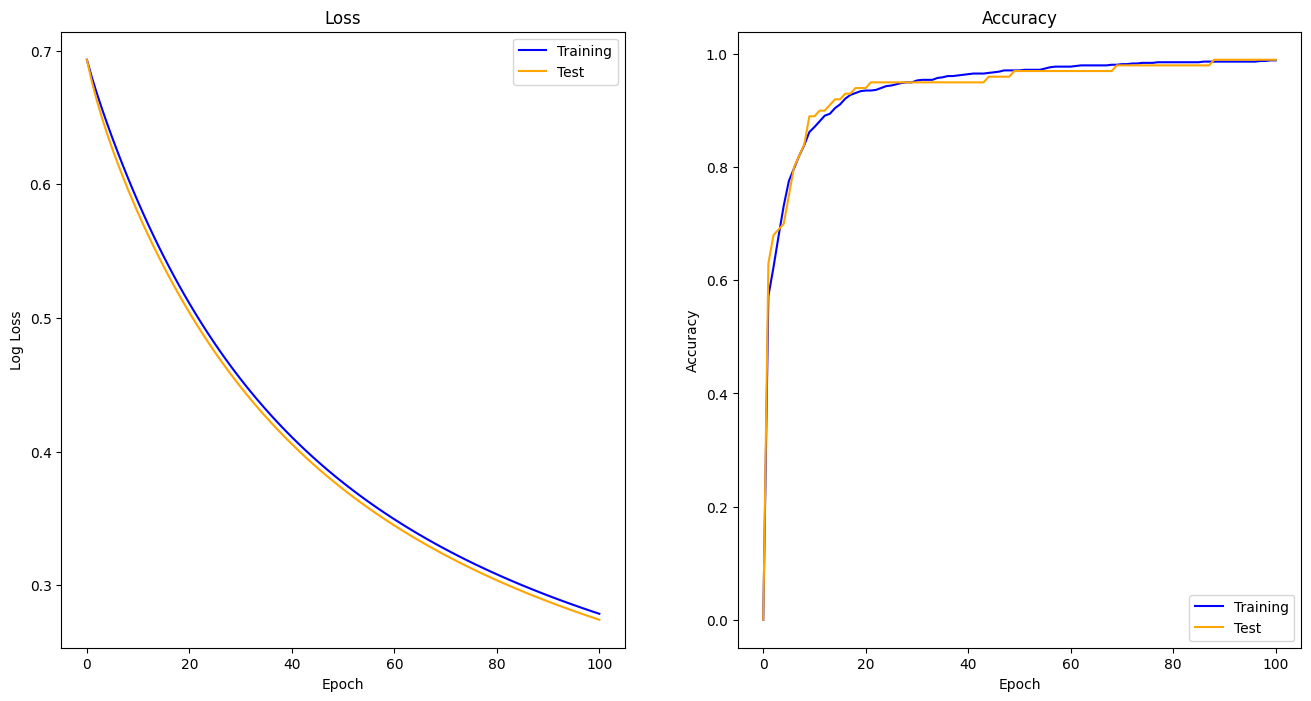

In [9]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(range(eps + 1), metrics['loss_train'], c='blue', label='Training')
plt.plot(range(eps + 1), metrics['loss_test'], c='orange', label='Test')
plt.legend(loc='upper right')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')

plt.subplot(1, 2, 2)
plt.plot(range(eps + 1), metrics['acc_train'], c='blue', label='Training')
plt.plot(range(eps + 1), metrics['acc_test'], c='orange', label='Test')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

However, real-world data is never black-and-white; there is never a clear division in the predictors. We will now look at data for car customers that contains information on their user identification numbers, genders, ages, and annual salaries in addition to whether they purchased a car. User IDs should not affect the purchase decision, so this is removed from the data frame. Because gender is displayed as words, it is converted to numbers (0 for females, 1 for males). Similarly to the generated numbers, the car data is normalized and split into training and validation sets.

In [10]:
cars = pd.read_csv('car_data.csv')
print(cars.head(10))
cars = cars[['Gender', 'Age', 'AnnualSalary', 'Purchased']]
cars = cars.transform(lambda x: (x == 'Male') * 1 if x.name == 'Gender' else x)
cars = normalize_minmax(cars.to_numpy())
train, test = train_test_split(cars, test_size=0.1, shuffle=True, random_state=29)

   User ID  Gender  Age  AnnualSalary  Purchased
0      385    Male   35         20000          0
1      681    Male   40         43500          0
2      353    Male   49         74000          0
3      895    Male   40        107500          1
4      661    Male   25         79000          0
5      846  Female   47         33500          1
6      219  Female   46        132500          1
7      588    Male   42         64000          0
8       85  Female   30         84500          0
9      465    Male   41         52000          0


We initialize the $\beta$-values and set the number of epochs, learning rate, and decision threshold then train the model.

In [11]:
betas = np.zeros(cars.shape[1])

eps = 250
lr = 5
thresh = 0.5 + 1e-13
metrics = iterate(betas, train, test, eps, lr, thresh)

Again, the loss and accuracy start quite far from desirable, but through the progression of the regression model, they improve substantially. The accuracy does not come as close to perfect as with the generated data, which is expected as explained above.

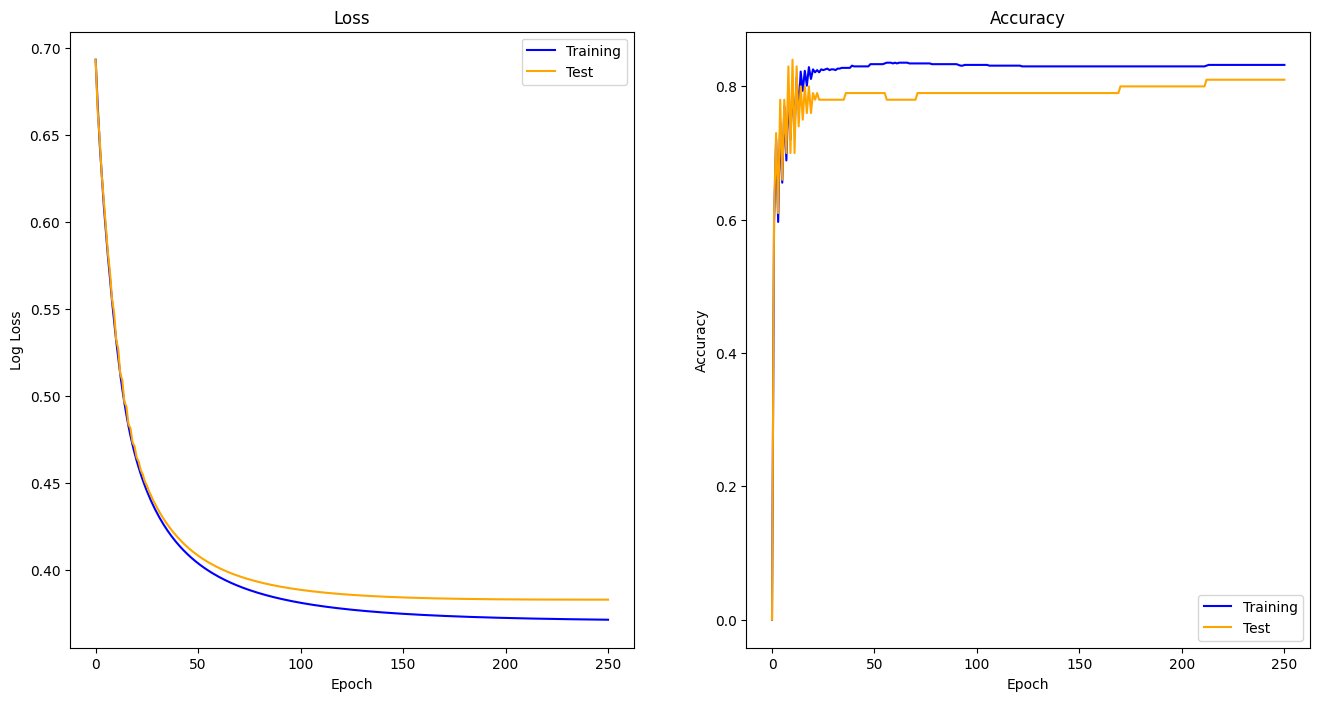

In [12]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(range(eps + 1), metrics['loss_train'], c='blue', label='Training')
plt.plot(range(eps + 1), metrics['loss_test'], c='orange', label='Test')
plt.legend(loc='upper right')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')

plt.subplot(1, 2, 2)
plt.plot(range(eps + 1), metrics['acc_train'], c='blue', label='Training')
plt.plot(range(eps + 1), metrics['acc_test'], c='orange', label='Test')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

We can now use this model to predict whether a customer will purchase a car with decent accuracy. If you would like to use a custom data point or set, ensure that it is normalized before being used.

In [ ]:
def predict_on_test(pred):
    actual = test[pred][cars.shape[1] - 1]
    decision_actual = 'Purchase' if actual >= 0.5 else 'No Purchase'
    prediction = prob(betas, test[pred][:cars.shape[1] - 1])
    decision_pred = 'Purchase' if prediction >= 0.5 else 'No Purchase'
    print('Actual Decision:    {} ({})'.format(actual, decision_actual))
    print('Predicted Decision: {} ({})'.format(prediction, decision_pred))

The model can predict this data point correctly with high confidence...

In [37]:
predict_on_test(22)

Actual Decision:    1.0 (Purchase)
Predicted Decision: 0.9866406785884819 (Purchase)


... but it can also be very wrong. Some predictor variables might not affect the purchase decision and could actually disrupt the regression.

In [87]:
predict_on_test(53)

Actual Decision:    1.0 (Purchase)
Predicted Decision: 0.3558816819826972 (No Purchase)


## Final Thoughts
Logistic regression is an efficient classification method and introduces the concepts of probability and confidence, which frequently appear in other classification techniques. Since it uses a basic implementation of gradient descent, computation time is quick and does not use as many resources as deep learning would. With that said, logistic regression does have some weaknesses when compared to other methods. Like linear regression, it does not perform well when a predictor variable does not actually affect the class (outcome variable). A decision tree would most likely perform better and can be used for both numerical regression and classification.